In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mafaulda as src
import numpy as np

from scipy.signal import find_peaks
from scipy.signal import butter, lfilter

file_list = [
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_40percent__1.tsv',
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_40percent__2.tsv',
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_40percent_speed_up__3.tsv',
    'raw_data/air_conditioning/excool_digitalis/high_pressure_pump_80percent__4.tsv',
    'raw_data/air_conditioning/shc2/compressor_shc2_klima4_bad.tsv',
    'raw_data/air_conditioning/shc2/compressor_shc2_klima5_good.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_top_1.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_top_2.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_top_3.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_base.tsv',
    'raw_data/air_conditioning/vertiv_digitalis/compressor_side.tsv'
]
src_file = file_list[10]

kind = 'beaglebone' # beaglebone, beaglebone_w_timer, boat

T_WAVEFORM = 5
T_SEC = T_WAVEFORM
NFFT = 512

if kind == 'beaglebone':
    # Fan
    Fs = 1160 # 1160 Hz +/-150 Hz (1020 - 1340 Hz)
    # src_file = 'raw_data/fan_test/fan_speed_3_4000.tsv'
    ts = pd.read_csv(src_file, delimiter='\t', index_col=False, header=None, names=['x', 'y', 'z'])
    # Calculate amplitude in m/s^2 Beaglebone Black ADC and ADXL335 resolution (VIN 1.8V, 12bits)
    for dim in ts.columns:
        ts[dim] = ts[dim] * (1800 / 4096)  # ADC to mV
        ts[dim] = (ts[dim] / 180) * 9.81  # mV to m/s^2 (180 mV/g)
        ts[dim] -= ts[dim].mean()

    ts['t'] = ts.index * (1 / Fs)

elif kind == 'beaglebone_w_timer':
    # Fan
    Fs = 1160 # 1160 Hz +/-150 Hz (1020 - 1340 Hz)
    # src_file = 'raw_data/fan_test/fan_speed_3_4000.tsv'
    ts = pd.read_csv(src_file, delimiter='\t', index_col=False, header=None, names=['x', 'y', 'z', 'diff'])
    ts = ts.iloc[1:,:]
    
    # Calculate amplitude in m/s^2 Beaglebone Black ADC and ADXL335 resolution (VIN 1.8V, 12bits)
    for dim in ts.columns:
        ts[dim] = ts[dim] * (1800 / 4096)  # ADC to mV
        ts[dim] = (ts[dim] / 180) * 9.81  # mV to m/s^2 (180 mV/g)
        ts[dim] -= ts[dim].mean()

    ts['t'] = t['diff'].cumsum()
    Fs = ts['t'].mean()

elif kind == 'boat':
    # Boat
    Fs = 200
    #src_file = 'boat/Boat__2.txt'
    ts = pd.read_csv(src_file, delimiter=' ')
    ts['t'] = ts['t'].cumsum()
    for dim in ts.columns:
        ts[dim] -= ts[dim].mean()

ts.set_index('t', inplace=True)
ts

,x,y,z
t,,,
0.000000,2.173701,-0.498777,0.396438
0.000862,2.149750,-0.163475,0.731741
0.001724,1.287543,-0.858030,0.755691
0.002586,0.976191,-2.462693,0.827542
0.003448,0.497187,-3.037498,0.971243
...,...,...,...
11.587931,0.066083,-4.785862,0.588040
11.588793,0.329536,-3.995506,0.300638
11.589655,-0.269219,-3.612303,-0.082566


In [2]:
ts.describe()

,x,y,z
count,1.344700e+04,1.344700e+04,1.344700e+04
mean,-2.271602e-15,-7.281385e-16,4.615595e-15
std,1.305294e+00,2.390201e+00,7.334218e-01
min,-2.496587e+00,-5.049315e+00,-1.687229e+00
25%,-1.155377e+00,-1.959739e+00,-5.136691e-01
50%,1.818306e-02,2.436786e-01,8.508580e-02
75%,1.095942e+00,2.099819e+00,5.161893e-01
max,2.628754e+00,4.291262e+00,1.617898e+00


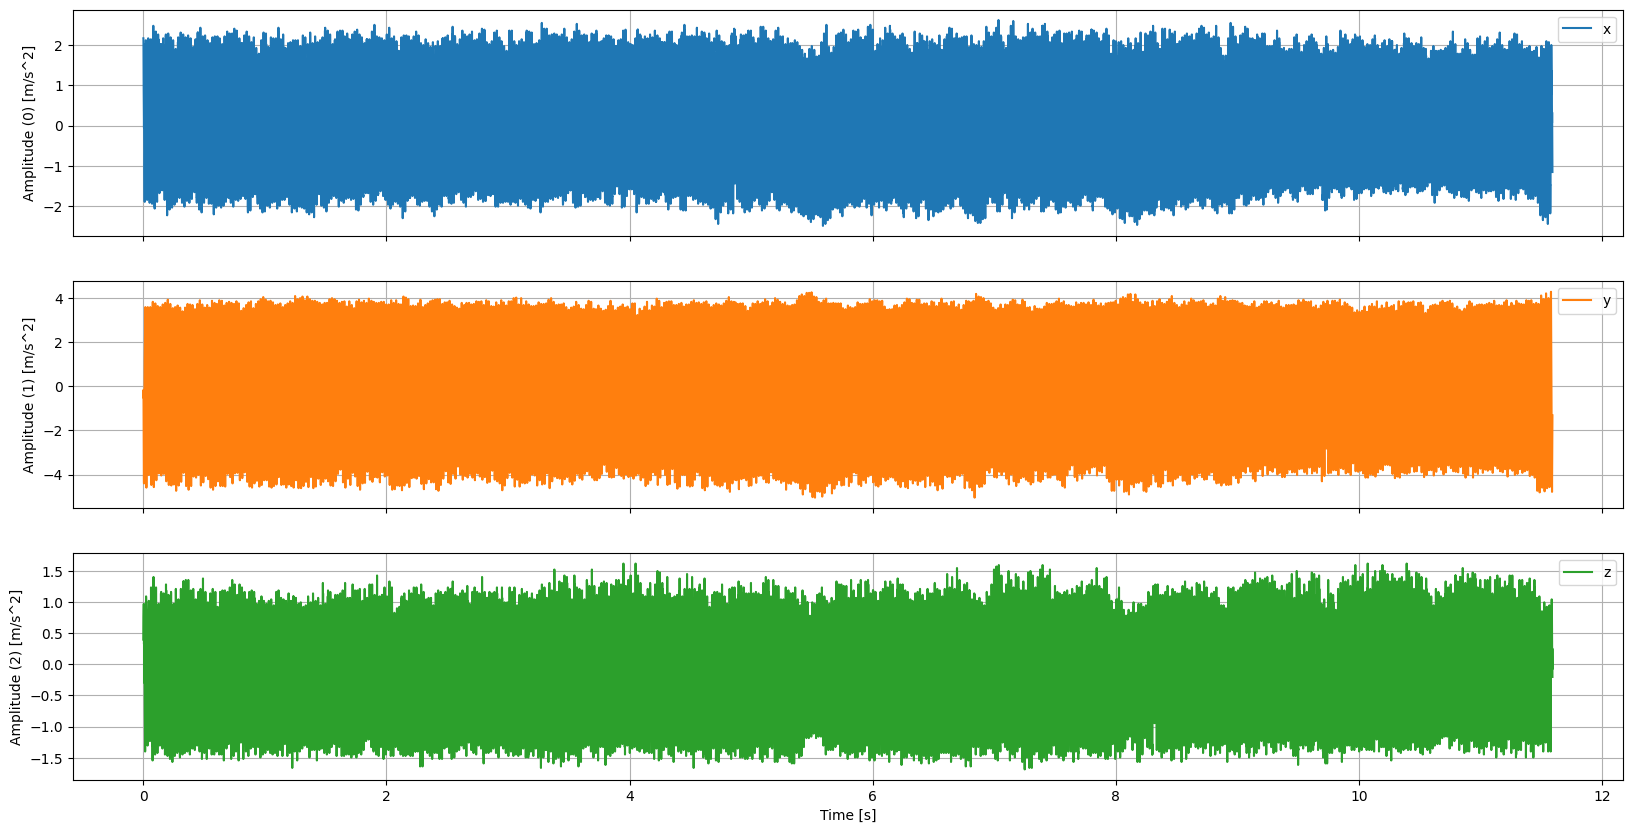

In [3]:
ax = ts[['x', 'y', 'z']].plot(figsize=(20, 10), grid=True, subplots=True)
for i in range(3):
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(f'Amplitude ({i}) [m/s^2]')
plt.savefig('waveform.png')

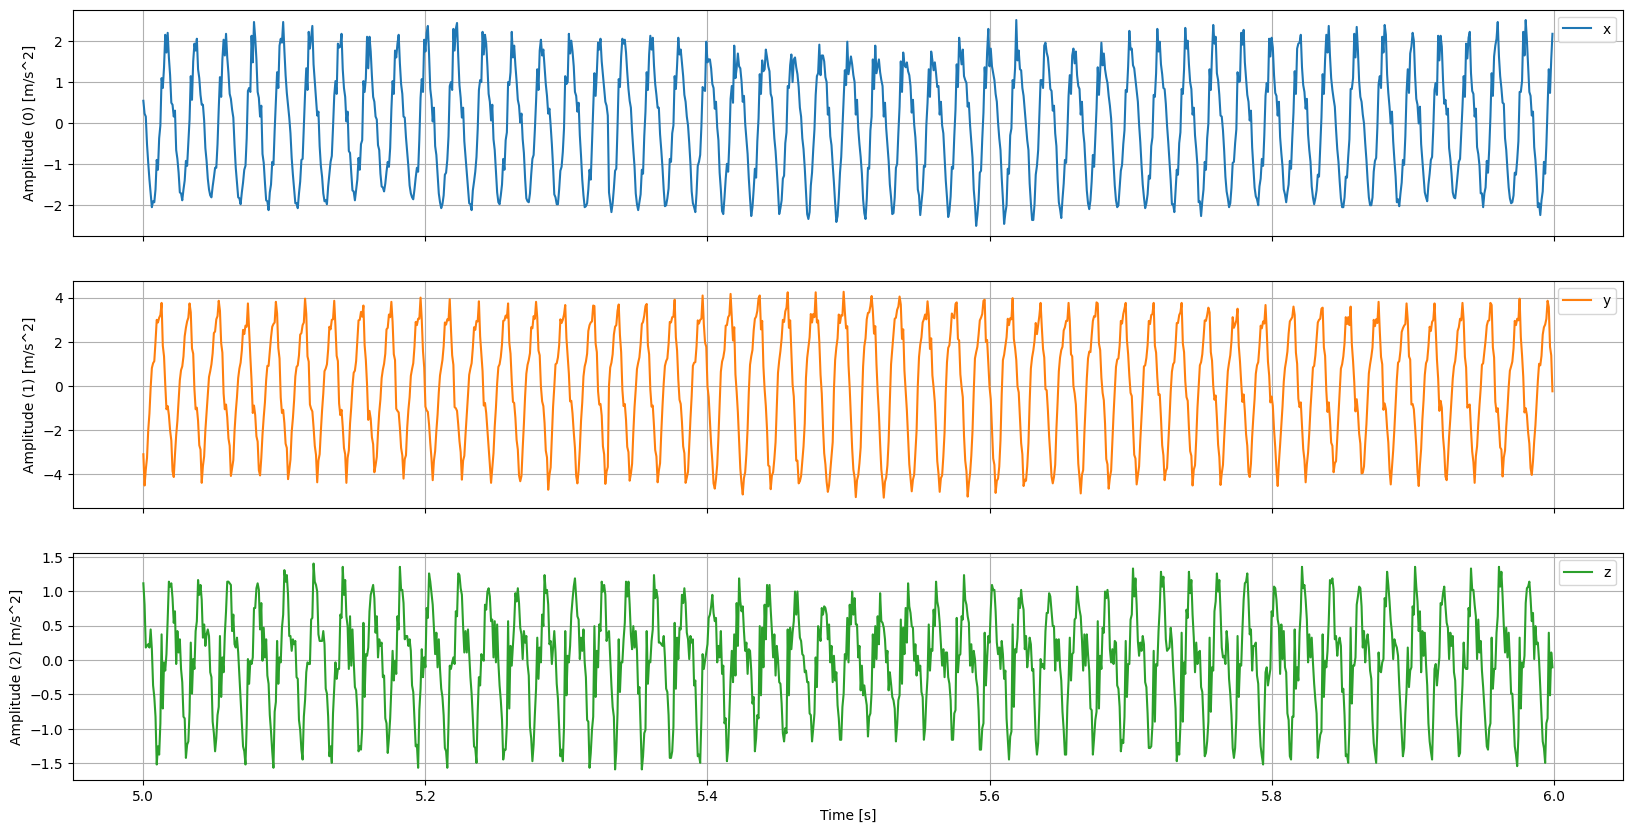

In [4]:
ax = ts[['x', 'y', 'z']].iloc[int(T_WAVEFORM*Fs):int(T_WAVEFORM*Fs)+Fs].plot(figsize=(20, 10), grid=True, subplots=True)
for i in range(3):
    ax[i].set_xlabel('Time [s]')
    ax[i].set_ylabel(f'Amplitude ({i}) [m/s^2]')
plt.savefig('waveform_zoom.png')

In [5]:
def spectogram(x):
    plt.figure(figsize=(20, 4))
    Pxx, freqs, t, im = plt.specgram(x, NFFT=NFFT, Fs=Fs, mode='magnitude', scale='dB')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    src.resolution_calc(Fs, NFFT)
    return freqs, Pxx


def spectrum_slice(Pxx, t):
    fig, ax = plt.subplots(2, 1, figsize=(20, 8))
    n = (Fs * t) // NFFT + 1

    dB = 20 * np.log10(Pxx.T[n] / 0.000001)
    ax[0].plot(freqs, dB)      # 1 dB = 1 um/s^2
    ax[0].grid(True)
    ax[0].set_xlabel('Frequency [Hz]')
    ax[0].set_ylabel('Amplitude [dB]')
    
    ax[1].plot(freqs, Pxx.T[n])
    ax[1].grid(True)
    ax[1].set_xlabel('Frequency [Hz]')
    ax[1].set_ylabel('Amplitude [m/s^2]')
    return n


def get_max_frequency(freqs, Pxx, i):
    max_freq = freqs[np.argmax(Pxx.T[i])]
    print(f'Fundamental: {max_freq} Hz')
    return max_freq


def get_peaks(freqs, Pxx, i, top=5):
    amplitudes = Pxx.T[i]
    peaks, _ = find_peaks(amplitudes, distance=3)

    fundamental = get_max_frequency(freqs, Pxx, i)
    f_top = freqs[peaks[np.argsort(amplitudes[peaks])]][::-top]
    y_top = np.sort(amplitudes[peaks])[::-top]

    return pd.DataFrame({
        'f': f_top,
        'y': y_top,
        '1x': f_top / fundamental 
    })


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y
    

Window size: 512
Heinsenberg box
	Time step: 441.37931034482756 ms
	Frequency step: 2.265625 Hz


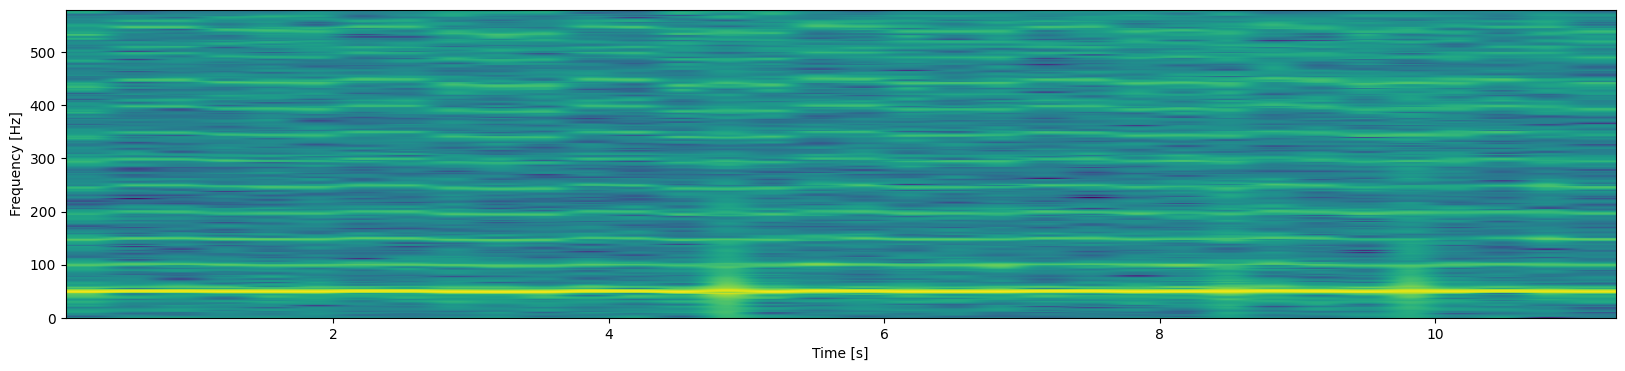

In [6]:
freqs, Pxx = spectogram(ts['x'])
plt.savefig(f'x_axis_fft_{NFFT}.png')

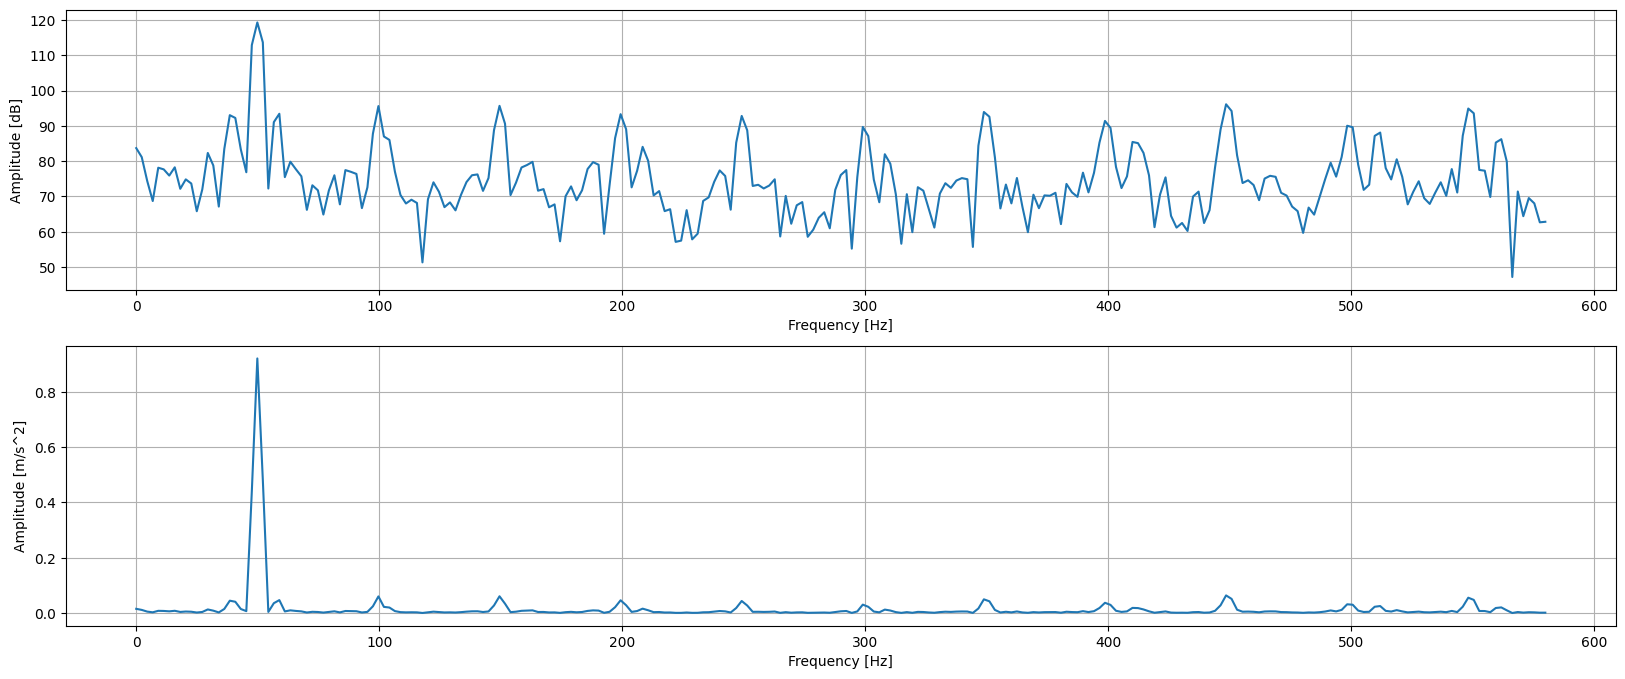

In [7]:
i_window = spectrum_slice(Pxx, T_SEC);
plt.savefig(f'x_axis_fft_{NFFT}_at_{T_SEC}s.png')

In [8]:
x_fundamental = get_max_frequency(freqs, Pxx, i_window)

Fundamental: 49.84375 Hz


In [9]:
get_peaks(freqs, Pxx, i_window)

Fundamental: 49.84375 Hz


,f,y,1x
0,49.843750,0.921125,1.000000
1,348.906250,0.049658,7.000000
2,398.750000,0.037113,8.000000
3,410.078125,0.018684,8.227273
4,163.125000,0.009767,3.272727
5,541.484375,0.007720,10.863636
6,140.468750,0.006483,2.818182
7,262.812500,0.005529,5.272727
8,382.890625,0.004752,7.681818
9,215.234375,0.003765,4.318182


Window size: 512
Heinsenberg box
	Time step: 441.37931034482756 ms
	Frequency step: 2.265625 Hz


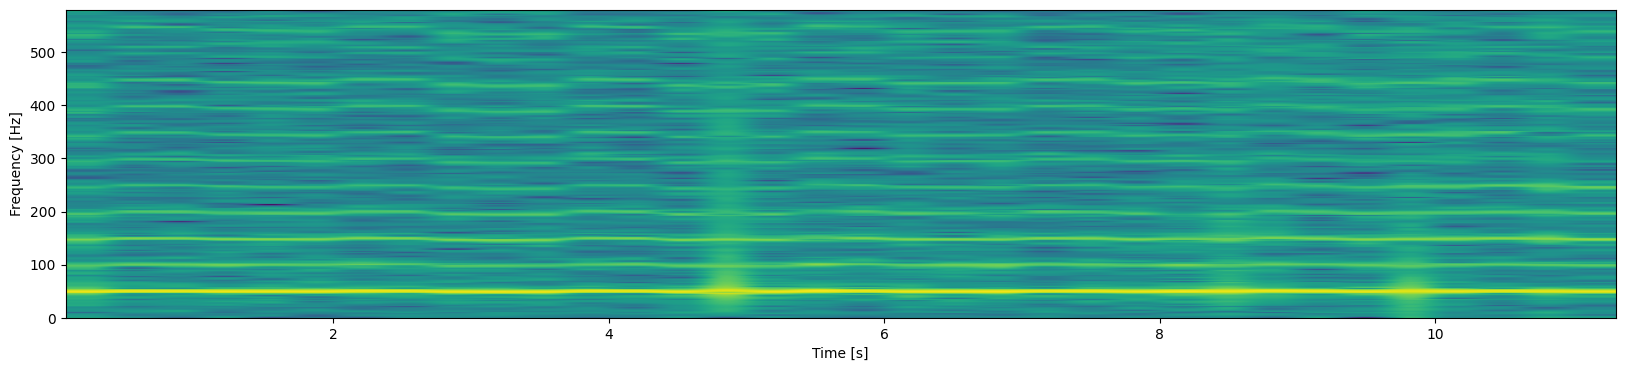

In [10]:
freqs, Pxx = spectogram(ts['y'])
plt.savefig(f'y_axis_fft_{NFFT}.png')

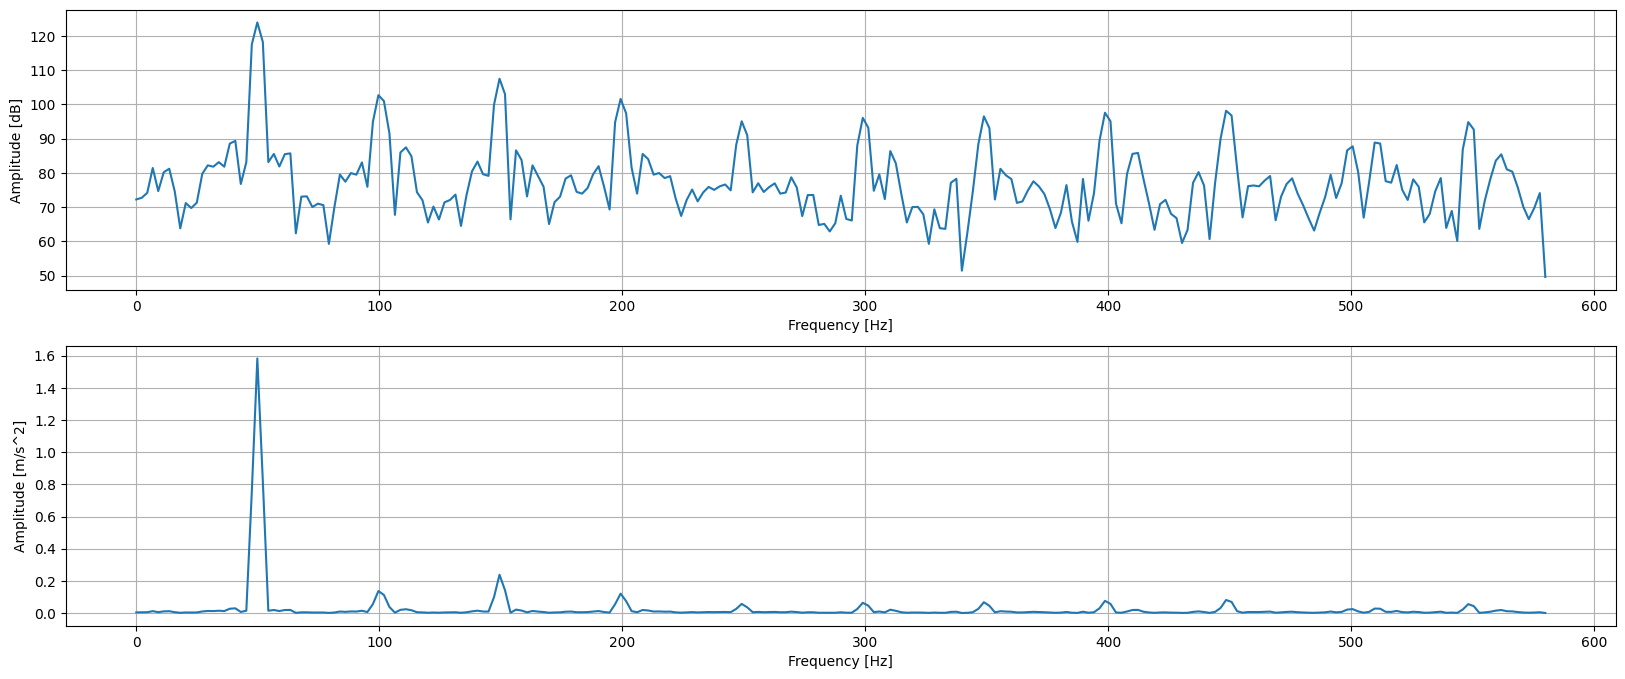

In [11]:
i_window = spectrum_slice(Pxx, T_SEC);
plt.savefig(f'y_axis_fft_{NFFT}_at_{T_SEC}s.png')

In [12]:
y_fundamental = get_max_frequency(freqs, Pxx, i_window)

Fundamental: 49.84375 Hz


In [13]:
get_peaks(freqs, Pxx, i_window)

Fundamental: 49.84375 Hz


,f,y,1x
0,49.843750,1.582481,1.000000
1,398.750000,0.075754,8.000000
2,40.781250,0.029370,0.818182
3,310.390625,0.020829,6.227273
4,561.875000,0.018690,11.272727
5,163.125000,0.012886,3.272727
6,437.265625,0.010253,8.772727
7,466.718750,0.009001,9.363636
8,389.687500,0.008155,7.818182
9,242.421875,0.006769,4.863636


Window size: 512
Heinsenberg box
	Time step: 441.37931034482756 ms
	Frequency step: 2.265625 Hz


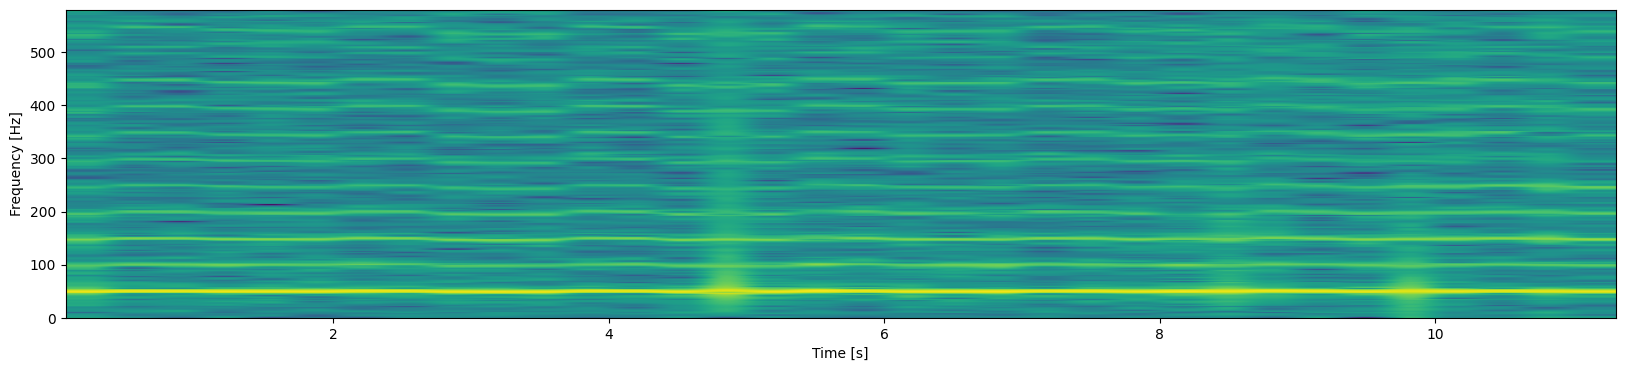

In [14]:
freqs, Pxx = spectogram(ts['y'])
plt.savefig(f'z_axis_fft_{NFFT}.png')

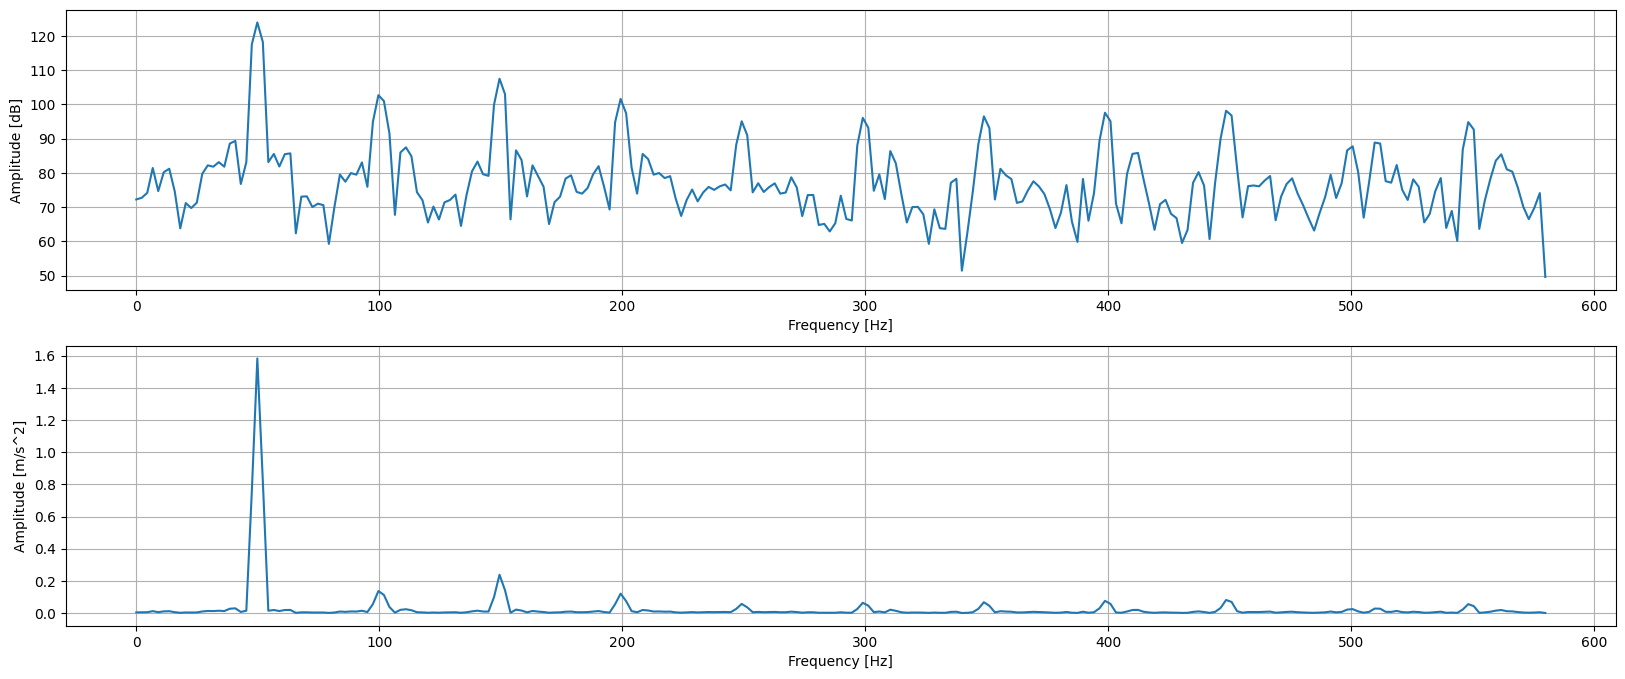

In [15]:
i_window = spectrum_slice(Pxx, T_SEC);
plt.savefig(f'z_axis_fft_{NFFT}_at_{T_SEC}s.png')

In [16]:
z_fundamental = get_max_frequency(freqs, Pxx, i_window)

Fundamental: 49.84375 Hz


In [17]:
get_peaks(freqs, Pxx, i_window)

Fundamental: 49.84375 Hz


,f,y,1x
0,49.843750,1.582481,1.000000
1,398.750000,0.075754,8.000000
2,40.781250,0.029370,0.818182
3,310.390625,0.020829,6.227273
4,561.875000,0.018690,11.272727
5,163.125000,0.012886,3.272727
6,437.265625,0.010253,8.772727
7,466.718750,0.009001,9.363636
8,389.687500,0.008155,7.818182
9,242.421875,0.006769,4.863636


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: >]], dtype=object)

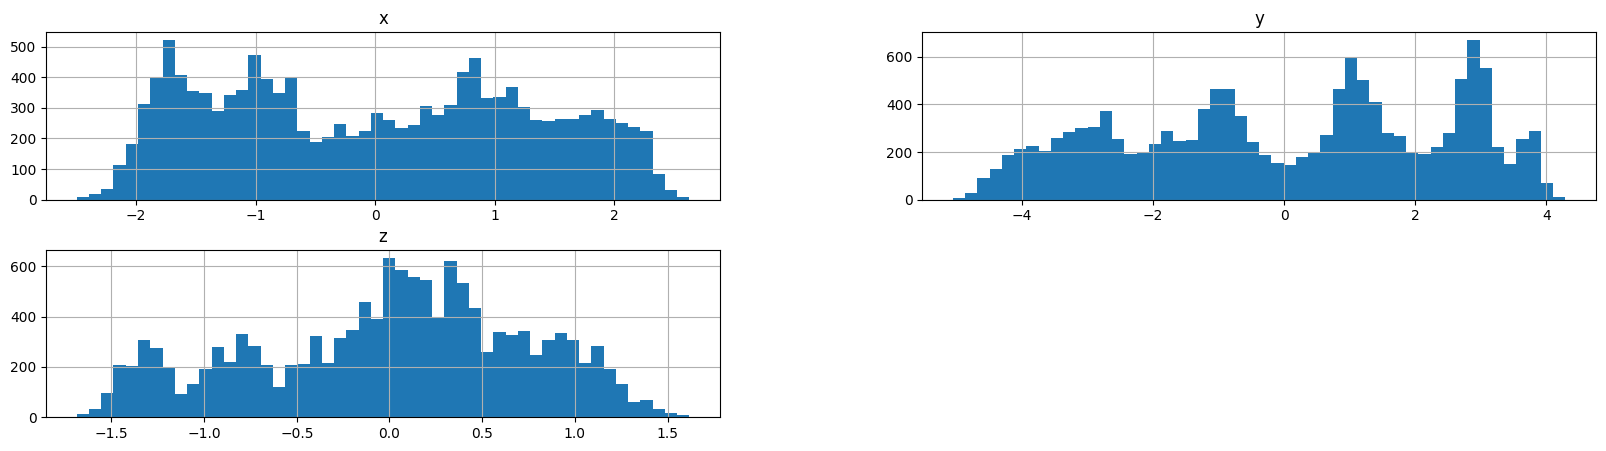

In [18]:
ts[['x', 'y', 'z']].hist(figsize=(20, 5), grid=True, bins=50)

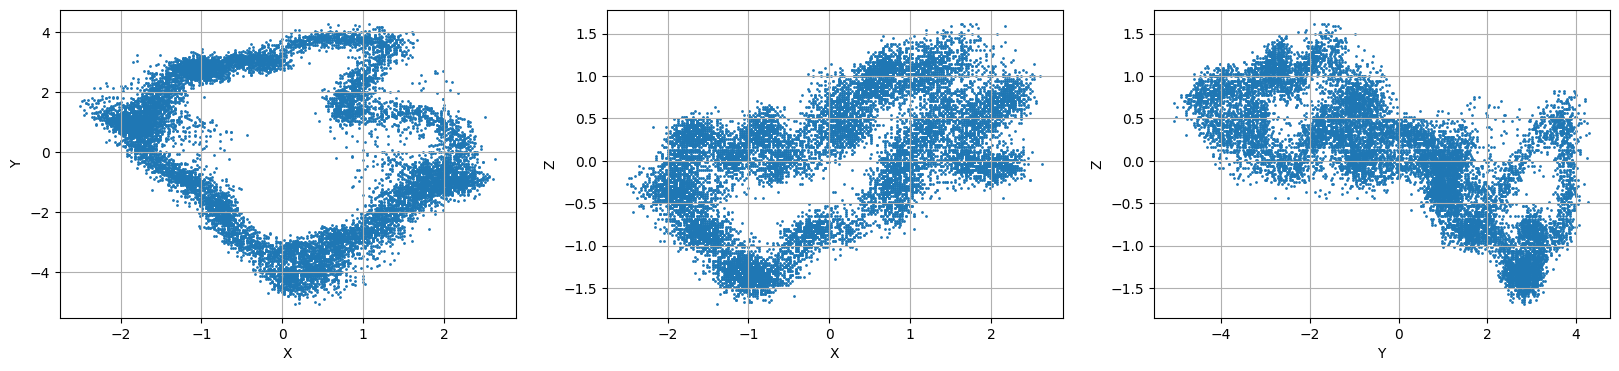

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i, col in enumerate([('x', 'y'), ('x', 'z'), ('y', 'z')]):
    ax[i].scatter(ts[col[0]], ts[col[1]], s=1)
    ax[i].grid(True)
    ax[i].set_xlabel(col[0].upper())
    ax[i].set_ylabel(col[1].upper())
    ax[i].grid(True)

plt.savefig('orbitals.png')

In [20]:
space = 5
ts['x_1x'] = butter_bandpass_filter(ts['x'], x_fundamental - space, x_fundamental + space, Fs)
ts['y_1x'] = butter_bandpass_filter(ts['y'], y_fundamental - space, y_fundamental + space, Fs)
ts['z_1x'] = butter_bandpass_filter(ts['z'], z_fundamental - space, z_fundamental + space, Fs)

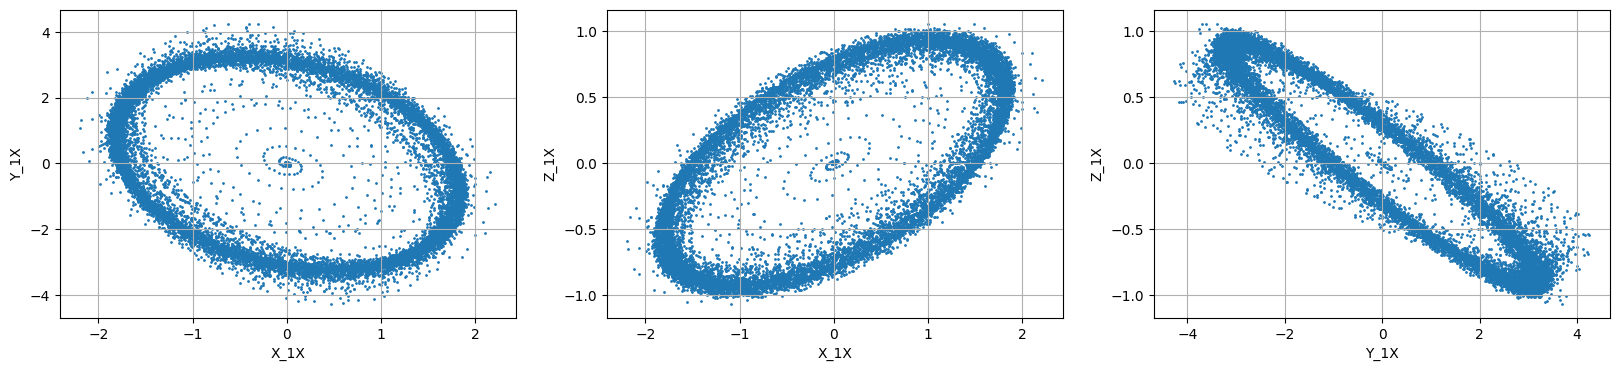

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

for i, col in enumerate([('x_1x', 'y_1x'), ('x_1x', 'z_1x'), ('y_1x', 'z_1x')]):
    ax[i].scatter(ts[col[0]], ts[col[1]], s=1)
    ax[i].grid(True)
    ax[i].set_xlabel(col[0].upper())
    ax[i].set_ylabel(col[1].upper())
    ax[i].grid(True)

plt.savefig('orbitals_1x.png')